In [57]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [58]:
print(cv2.__version__)

4.6.0


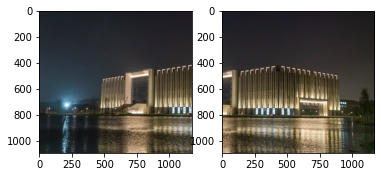

In [59]:
# 使用cv2读取
img_left = cv2.imread('images/1.jpg', 1)
img_right = cv2.imread('images/2.jpg', 1)

plt.subplot(121)
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.show()

In [60]:
def detect(image):
    # 转化为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 创建SIFT生成器
    # descriptor是一个对象，这里使用的是SIFT算法
    descriptor = cv2.xfeatures2d.SIFT_create()
    # 检测特征点及其描述子（128维向量）
    kps, features = descriptor.detectAndCompute(image, None)
    return (kps,features)


特征点数：7108


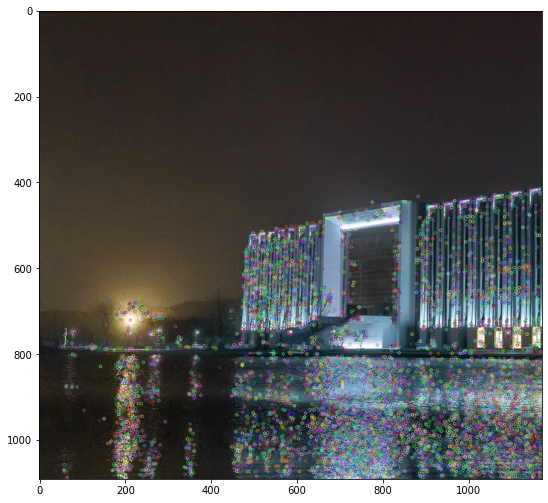

In [61]:
# 可以看下特征点(若果发现几次运行特征点数目不同，要重新读取图片)
def show_points(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    descriptor = cv2.xfeatures2d.SIFT_create()
    kps, features = descriptor.detectAndCompute(image, None)
    print(f"特征点数：{len(kps)}")
    img_left_points = cv2.drawKeypoints(img_left, kps, img_left)
    plt.figure(figsize=(9,9)) 
    plt.imshow(img_left_points)
show_points(img_left)


In [62]:
def match_keypoints(kps_left,kps_right,features_left,features_right,ratio,threshold):
    """
    kpsA,kpsB,featureA,featureB: 两张图的特征点坐标及特征向量
    threshold: 阀值
    
    """
    # 建立暴力匹配器
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    # 使用knn检测，匹配left,right图的特征点
    raw_matches = matcher.knnMatch(features_left, features_right, 2)
    print(len(raw_matches))
    matches = []  # 存坐标，为了后面
    good = [] # 存对象，为了后面的演示
    # 筛选匹配点
    for m in raw_matches:
        # 筛选条件
#         print(m[0].distance,m[1].distance)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            good.append([m[0]])
            matches.append((m[0].queryIdx, m[0].trainIdx))
            """
            queryIdx：测试图像的特征点描述符的下标==>img_keft
            trainIdx：样本图像的特征点描述符下标==>img_right
            distance：代表这怡翠匹配的特征点描述符的欧式距离，数值越小也就说明俩个特征点越相近。
            """
    # 特征点对数大于4就够用来构建变换矩阵了
    kps_left = np.float32([kp.pt for kp in kps_left])
    kps_right = np.float32([kp.pt for kp in kps_right])
    print("特征点对数",len(matches))
    if len(matches) > 4:
        # 获取匹配点坐标
        pts_left = np.float32([kps_left[i] for (i,_) in matches])
        pts_right = np.float32([kps_right[i] for (_,i) in matches])
        # 计算变换矩阵(采用ransac算法从pts中选择一部分点)
        H,status = cv2.findHomography(pts_right, pts_left, cv2.RANSAC, threshold)
        return (matches, H, good)
    return None


7108
特征点对数 3173


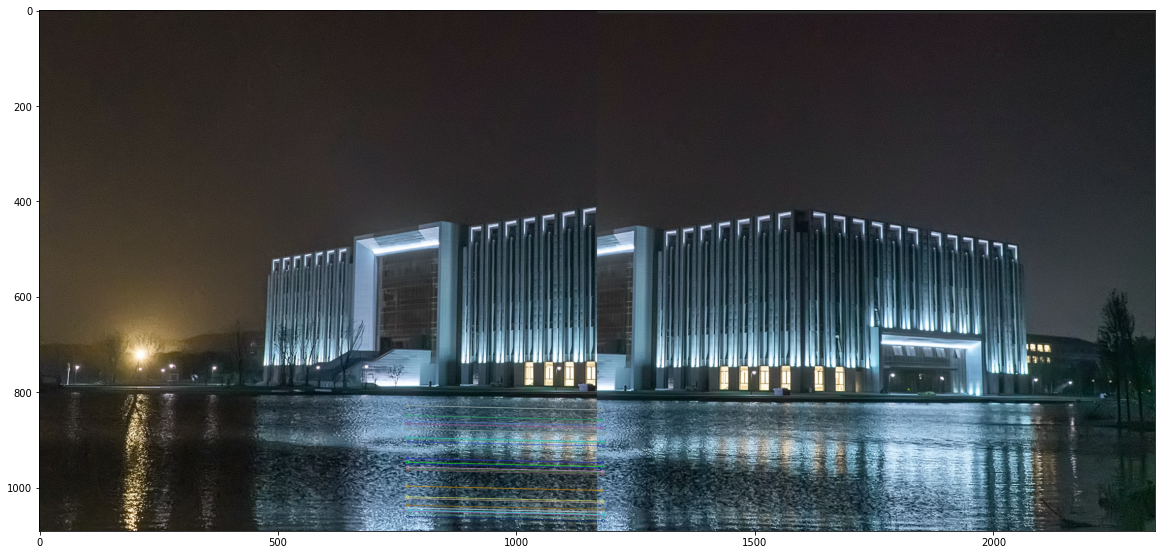

In [63]:
img_left = cv2.imread('images/1.jpg', 1)
img_right = cv2.imread('images/2.jpg', 1)

kps_left, features_left = detect(img_left)
kps_right, features_right = detect(img_right)
matches, H, good = match_keypoints(kps_left,kps_right,features_left,features_right,0.01,0.99)
# print(matches)
img = cv2.drawMatchesKnn(img_left,kps_left,img_right,kps_right,good[:30],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,20))
plt.imshow(img)

In [64]:
def drawMatches(img_left, img_right, kps_left, kps_right, matches, H):
    # 获取图片宽度和高度
    h_left, w_left = img_left.shape[:2]
    h_right, w_right = img_right.shape[:2]
    """对imgB进行透视变换
    由于透视变换会改变图片场景的大小，导致部分图片内容看不到
    所以对图片进行扩展:高度取最高的，宽度为两者相加"""
    image = np.zeros((max(h_left, h_right), w_left+w_right, 3), dtype='uint8')
    # 初始化
    image[0:h_left, 0:w_left] = img_right
    """利用以获得的单应性矩阵进行变透视换"""
    image = cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))#(w,h
    """将透视变换后的图片与另一张图片进行拼接"""
    image[0:h_left, 0:w_left] = img_left
    return image

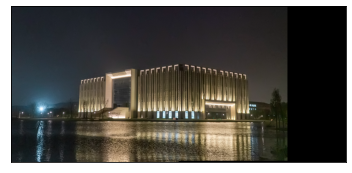

In [65]:
vis = drawMatches(img_left, img_right, kps_left, kps_right, matches, H)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

In [66]:
# 现在该定义一个主函数了
def main(img_left,img_right, size=(20,20)):
    # 模块一：提取特征
    kps_left, features_left = detect(img_left)
    kps_right, features_right = detect(img_right)
    # 模块二：特征匹配
    matches, H, good = match_keypoints(kps_left,kps_right,features_left,features_right,0.01,0.99)
    # 模块三：透视变换-拼接
    vis = drawMatches(img_left, img_right, kps_left, kps_right, matches, H)
    # show
    plt.figure(figsize= size)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.show()


7108
特征点对数 3173


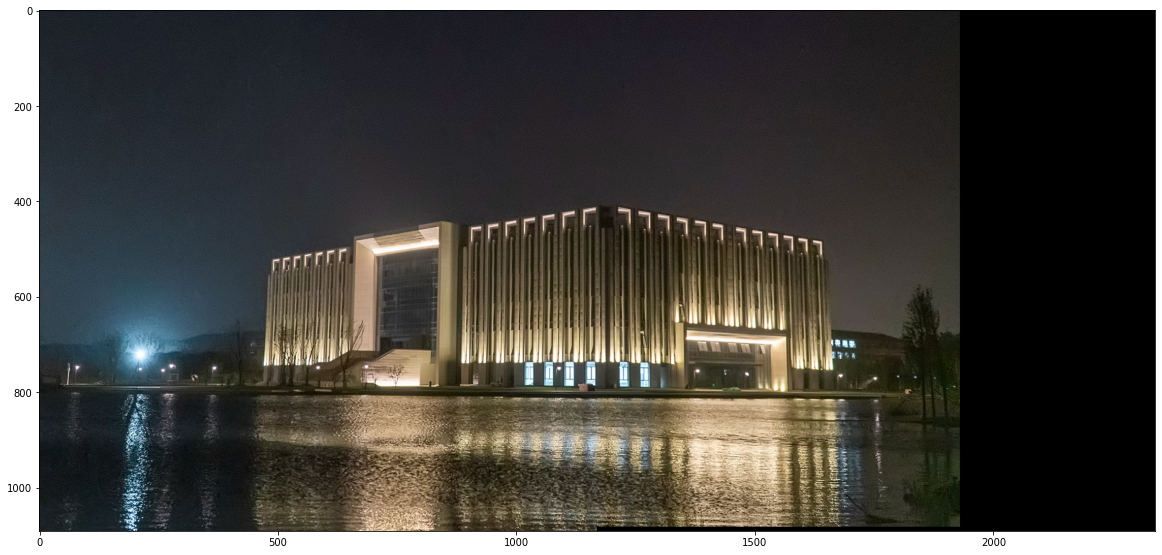

In [67]:
# 读取图片
img_left = cv2.imread('images/1.jpg', 1)
img_right = cv2.imread('images/2.jpg', 1)
main(img_left,img_right)

对比

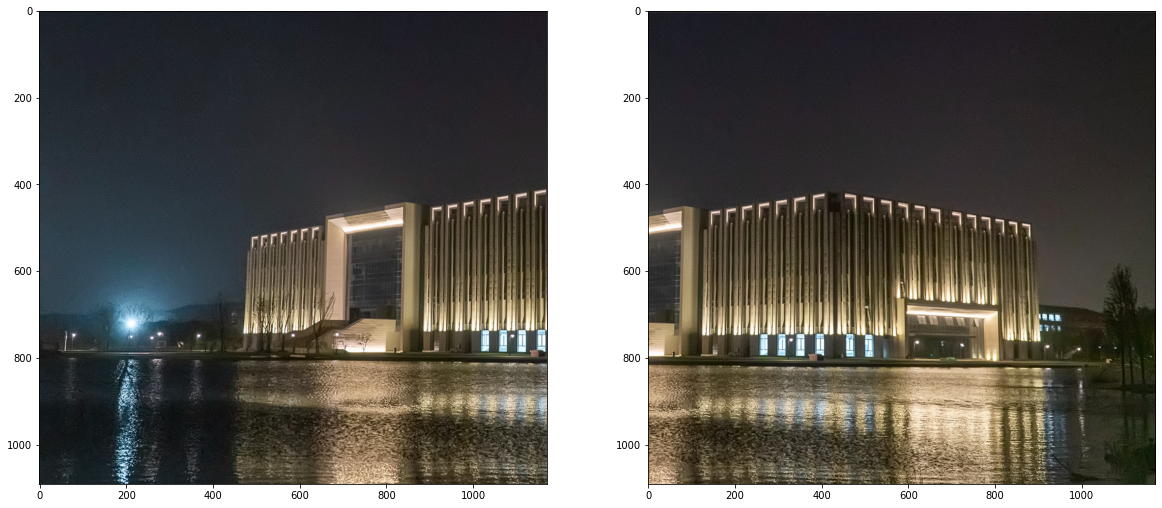

In [68]:
plt.figure(figsize= (20,20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.show()